In [19]:
# Library Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.spatial import KDTree
import seaborn as sns

from aRead import readAREPO
from peakFilteringFunctions import allFilters
import constants as c


### Peak Identification

In [2]:
# Load in the snapshot data
data1 = readAREPO("/home/ca-mcusack/simulationRuns/UV1/cloudUV1_041.hdf5", 1)
data10 = readAREPO("/home/ca-mcusack/simulationRuns/UV10/cloudUV10_042.hdf5", 1)
data100 = readAREPO("/home/ca-mcusack/simulationRuns/UV100/cloudUV100_077.hdf5", 1)
data1000 = readAREPO("/home/ca-mcusack/simulationRuns/UV1000/cloudUV1000_072.hdf5", 1)

In [99]:
# Function to get the distances between peaks that we identify
def getPeakDistances(data):
    # Find the peaks
    peaks = np.where(data.maxPotential == 1)[0]
    passTests, jL = allFilters(data, densityThreshold=1e6*1.4*1.66e-24)
    truePeaks = np.where(passTests == 1)
    peaks = peaks[truePeaks]

    # Extract peaks
    x = data.x[peaks]
    y = data.y[peaks]
    z = data.z[peaks]

    # Create a KDTree with the peak data
    positions = np.array([x, y, z]).T
    tree = KDTree(positions)

    # Find nearest neighbours for all the peaks
    nearest = tree.query(positions, 2)
    neighbours = nearest[0][:,1]

    return neighbours, jL, truePeaks

In [100]:
# Get the distances between the peaks and the peak IDs
n1, j1, p1 = getPeakDistances(data1)
n10, j10, p10 = getPeakDistances(data10)
n100, j100, p100 = getPeakDistances(data100)
n1000, j1000, p1000 = getPeakDistances(data1000)

Text(0.5, 0, '$\\rm \\gamma_{SFR}$')

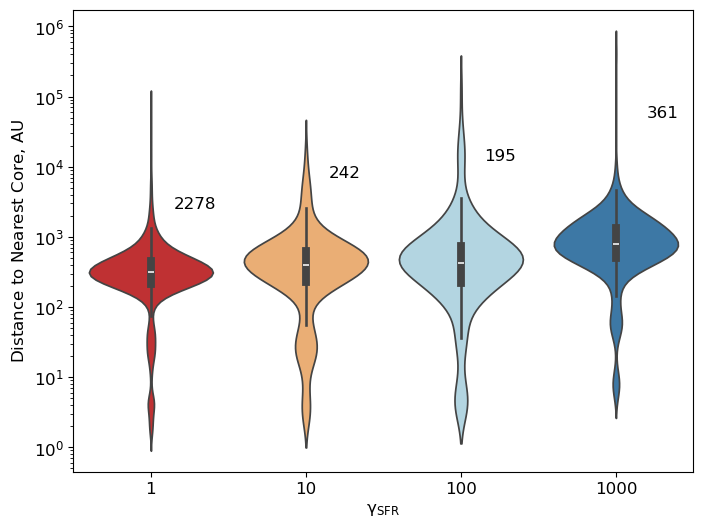

In [101]:
# Create the figure
plt.figure(figsize=(8,6))
matplotlib.rcParams.update({'font.size': 12})

# Create dictionary containing the data
data = {
    "1": n1/1.5e13,
    "10": n10/1.5e13,
    "100": n100/1.5e13,
    "1000": n1000/1.5e13,
}

colors = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]

# Plot the data and format
sns.violinplot(data, log_scale=True, palette=colors)

# Add the number of peaks 
plt.text(0.15, 2.5e3, len(n1))
plt.text(1.15, 7e3,len(n10))
plt.text(2.15, 1.2e4, len(n100))
plt.text(3.2, 5e4, len(n1000))

plt.ylabel("Distance to Nearest Core, $\\rm AU$")
plt.xlabel("$\\rm \gamma_{SFR}$")

### Peak Masses

In [3]:
from radialProfiles import coreProfiles
from tqdm import tqdm
from numba import jit, prange

In [7]:
# Calculates the GPE of each particle 
@jit(nopython=True, parallel=True)
def findGPE(x, y, z, vx, vy, vz, T, m, centreID, rMax):
    # Find distances to the centre 
    rPeak = np.sqrt((x - x[centreID])**2 + (y - y[centreID])**2 + (z - z[centreID])**2)

    # Find centre velocity and remove
    vx -= vx[centreID]
    vy -= vy[centreID]
    vz -= vz[centreID]

    # Only get things less than our max radius
    x = x[rPeak < rMax]
    y = y[rPeak < rMax]
    z = z[rPeak < rMax]
    m = m[rPeak < rMax]
    vx = vx[rPeak < rMax]
    vy = vy[rPeak < rMax]
    vz = vz[rPeak < rMax]
    T = T[rPeak < rMax]
    rPeak = rPeak[rPeak < rMax]

    # Sort by radius
    rSorted = np.argsort(rPeak)

    # Array to store this particles gpe and support
    gpe = np.zeros(len(rSorted))
    ke = np.zeros(len(rSorted))

    for i in prange(len(rPeak)):
        thisParticle = rSorted[i]

        # Loop through all other particles now
        for j in range(len(rPeak[rPeak<rPeak[thisParticle]])):
            
            if i == j:
                pass
            else:
                otherParticle = rSorted[j]
                rParticles = np.sqrt((x[thisParticle] - x[otherParticle])**2 + (y[thisParticle] - y[otherParticle])**2 + (z[thisParticle] - z[otherParticle])**2)
                gpe[i] += 6.67e-8 * m[thisParticle] * m[otherParticle] / rParticles

        ke[i] = (1./2.) * m[thisParticle] * (vx[thisParticle]**2 + vy[thisParticle]**2 + vz[thisParticle]**2)

    gpeCumulative = np.cumsum(gpe)

    return rPeak[rSorted], gpe, gpeCumulative, ke

In [70]:
r, gpe, gpeC, ke = findGPE(data1.x, data1.y, data1.z, data1.vx, data1.vy, data1.vz, data1.gasTemp, data1.mass, peak1[ind], 5e18)

In [53]:
def jeansLength(T, n):
    top = 15 * 1.38e-16 * T
    bottom = 4 * np.pi * 6.67e-8 * n * (1.4 * 1.66e-24)**2
    return np.sqrt(top/bottom) 

/tmp/ipykernel_2857188/2029236896.py:3: RuntimeWarning: invalid value encountered in divide
  vp = gpeC/np.cumsum(ke)


Text(0, 0.5, 'Virial Parameter (GPE/KE)')

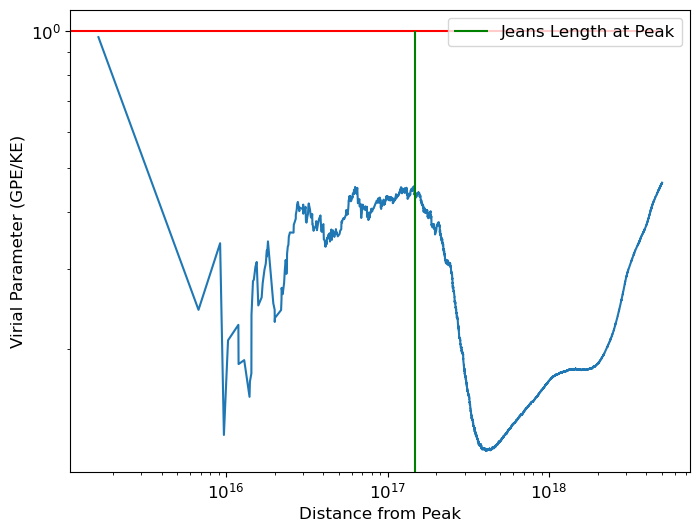

In [71]:
ind = 100

vp = gpeC/np.cumsum(ke)
jL = jeansLength(data1.gasTemp[peak1[ind]], data1.numberDensity[peak1[ind]])

plt.figure(figsize=(8,6))
plt.plot(r, vp)
plt.hlines(1, np.min(r), np.max(r), "r")
plt.vlines(jL, 0, 1, "g", label="Jeans Length at Peak")

plt.xscale("log")
plt.yscale("log")
plt.legend()

plt.xlabel("Distance from Peak")
plt.ylabel("Virial Parameter (GPE/KE)")

Text(0, 0.5, 'Number of Peaks')

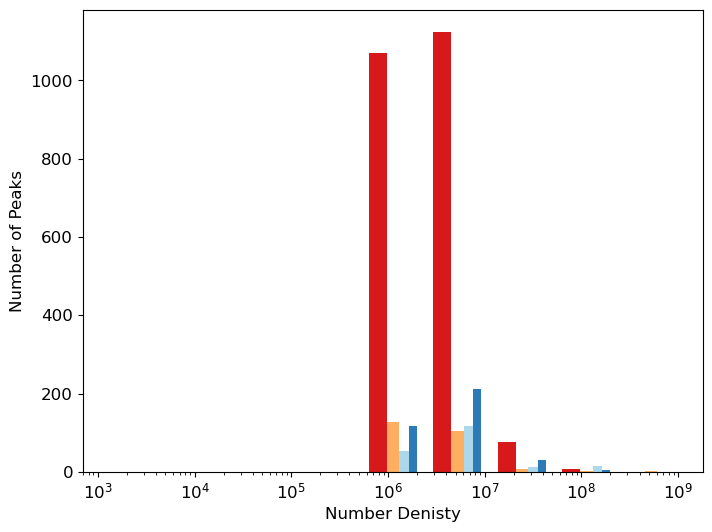

In [102]:
peak1 = np.where(data1.maxPotential == 1)[0]
peak1 = peak1[p1]

peak10 = np.where(data10.maxPotential == 1)[0]
peak10 = peak10[p10]

peak100 = np.where(data100.maxPotential == 1)[0]
peak100 = peak100[p100]

peak1000 = np.where(data1000.maxPotential == 1)[0]
peak1000 = peak1000[p1000]

n = [data1.numberDensity[peak1], data10.numberDensity[peak10], data100.numberDensity[peak100], data1000.numberDensity[peak1000]]
col = [c.colours()[0], c.colours()[1], c.colours()[3], c.colours()[4]]
bins = 10**np.linspace(3, 9, 10)

plt.figure(figsize=(8,6))
h = plt.hist(n, bins=bins, color=col)
plt.xscale("log")

plt.xlabel("Number Denisty")
plt.ylabel("Number of Peaks")

In [120]:
class testData():
    def __init__(self):
        return
    
data = testData()

data.x = np.random.uniform(-1e18, 1e18, int(1e5))
data.y = np.random.uniform(-1e18, 1e18, int(1e5))
data.z = np.random.uniform(-1e18, 1e18, int(1e5))
r = np.sqrt(data.x**2 + data.y**2 + data.z**2)
data.x = data.x[r<1e18]
data.y = data.y[r<1e18]
data.z = data.z[r<1e18]

data.mass = 0.01 * 1.991e33 * np.ones(len(data.x))

print("Expected GPE: {:.2e}".format((3/5) * c.G() * np.sum(data.mass)**2 / 1e18))

Expected GPE: 4.35e+46


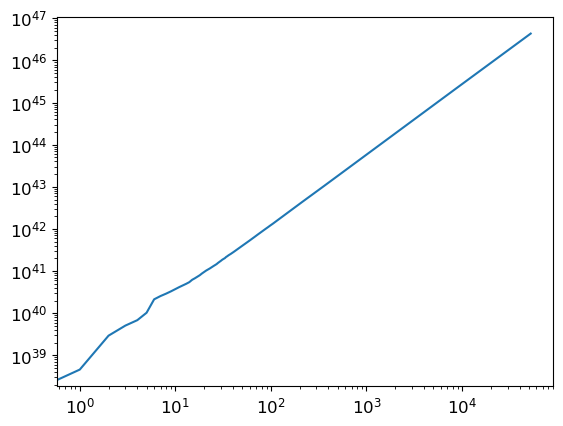

In [122]:
plt.loglog(gpeC)